In [ ]:
"""
среда 1:
    - можно выбрать n из m стратегий (рук)
        - число n - фиксированно
        - число m - постоянно растёт (со временем появляются новые стратегии. Мб могут изчезать старые)
    - каждая стратегия приносит награду
        - величина награды может убывать со временем
        - имеется заранее определённый широкий набор графиков награды (зависимость награды от времени)
        - все стратегии просчитываются заранее, до начала симуляции


среда 2:
    - можно выбрать любое количество из m стратегий (рук)
        - число m - большое и не изменяется
    - каждая стратегия требует вложения ресурсов
        - количество требуемых ресурсов разное и может меняться
    - каждая стратегия приносит награду
        - величина награды изменяется со временем
        - имеется заранее определённый широкий набор графиков награды
        - все стратегии просчитываются заранее, до начала симуляции
    - необходимые ресурсы и награда за них:
        - имеют некоторые зависимости от времени
        - могут быть цикличны (цикличность зависит от времени)
            - суточный, недельный, месячный, сезонный, годовой циклы
    - стратегии имеют свойства
        - ресурсы и награды могут быть завязаны на некоторые свойства стратегий
        - все стратегии могут иметь несколько пересекающихся свойств
"""

In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import Counter
from math import sqrt, log10

In [114]:

class Environment:
    
    def __init__(self, time_start, time_finish, step, earns_per_step):
        self.dt = step # шаг симуляции в секундах
        self.time_start = time_start # время начала симуляции
        self.time_finish = time_finish # время окончания симуляции
        
        
        self.earns = earns_per_step # общее количество очков, которые распределяются за 1 шаг
        self.arms = [] # руки (методом add_arm будут добавляться)
        self.selected_arms = [] # выбранные руки (содержит только их индексы. изменяются методом select_arms)
    
    def add_arm(self, arm_type=None):
        if arm_type is None:
            # если не задан тип, то ставим руку "по умолчанию"
            self.arms.append(Arm(time_start=self.time_start,
                                 time_finish=self.time_finish,
                                 noise_width=0.1))
            
        elif arm_type in ['default', 'linear']:
            # если задан тип по умолчанию или линейный, то ставим "по умолчанию"
            self.arms.append(Arm(time_start=self.time_start,
                                 time_finish=self.time_finish,
                                 noise_width=0.1))
            
        else:
            # если задан любой другой то ставим "по умолчанию"
            self.arms.append(Arm(time_start=self.time_start,
                                 time_finish=self.time_finish,
                                 noise_width=0.1))
     
    def _get_intervals(self, probabilities_list) -> (pd.DataFrame, float):
        # формируем список диапазонов на основе списка выпавших вероятностей
        
        # на входе список с набором вероятностей для каждой руки
        # на выходе нужно сформировать датафрейм где каждая строка содержит
        # диапазон значений для каждой вероятности, каждой руки
        prob_sum = 0
        output_list = []
        for num, prob in enumerate(probabilities_list):
            if prob < 0.001:
                continue
            
            min_val = prob_sum
            max_val = prob_sum + prob
            output_list.append({"arm_id": num, "min": min_val, "max": max_val})
            prob_sum = max_val
        return pd.DataFrame(output_list), prob_sum
            
    
    
    def run_env_sim(self):
        # запуск симуляции среды (каждую итерацию возвращаются все результаты)
        #sim_time_sec = 0 #####################
        each_step_distr = [] # распределение награды за каждый шаг (для отчета)
        self.selected_arms = [] # обнуляем выбранные руки. тогда первая итерация будет без награды
        
        time_range = int((self.time_finish - self.time_start).total_seconds())
        for sim_time_sec in tqdm(range(0, time_range, self.dt)):
            
            intervals, max_prob = self._get_intervals([arm.get_probability(sim_time_sec) for arm in self.arms])
            # суммируем вероятности и формируем диапазоны
            
            if max_prob < 0.001:
                each_step_distr.append({"time_sec": sim_time_sec, "arm_reward_counter": Counter()})
                continue
            # если за шаг накопилось слишком мало наград, то пропускаем шаг
            
            prob_distr = np.random.rand(int(self.earns*max_prob))*max_prob
            # генерируем self.earns случайных чисел в диапазоне суммы вероятностей (лучше с помощью нампи)
            
            arm_reward = Counter()
            for prob in prob_distr:
                arm_id = intervals[(intervals['min'] <= prob) & (intervals['max'] > prob)]['arm_id'].iloc[0]
                arm_reward[arm_id] += 1
            # распределяем числа по диапазонам и считаем очки заработанные
                
            
            step_result = {"time_sec": sim_time_sec, "arm_reward_counter": arm_reward}
            each_step_distr.append(step_result)
            # сохраняем результат за шаг для полного отчёта и для текущего шага
            
            
            yield step_result
        self.report_df = pd.DataFrame(each_step_distr)
    
    def select_arms(self, selected_arms: list):
        self.selected_arms = selected_arms
    
    def run_bandit_sim(self):
        # запуск симуляции среды при возвращении ограниченной информации о среде
        sim_time_sec = 0
        each_step_distr = []
        available_arms = []

        time_range = int((self.time_finish - self.time_start).total_seconds())
        for sim_time_sec in tqdm(range(0, time_range, self.dt)):
            
            intervals, max_prob = self._get_intervals([arm.get_probability(sim_time_sec) for arm in self.arms])
            # суммируем вероятности и формируем диапазоны
            
            
            if max_prob < 0.001:
                each_step_distr.append({"time_sec": sim_time_sec, "arm_reward_counter": Counter()})
                continue
            # если за шаг накопилось слишком мало наград, то пропускаем шаг
            
            prob_distr = np.random.rand(int(self.earns*max_prob))*max_prob
            # генерируем self.earns случайных чисел в диапазоне суммы вероятностей (лучше с помощью нампи)
            
            arm_reward = Counter()
            for prob in prob_distr:
                arm_id = intervals[(intervals['min'] <= prob) & (intervals['max'] > prob)]['arm_id'].iloc[0]
                arm_reward[arm_id] += 1
            # распределяем числа по диапазонам и считаем очки заработанные
                
            
            step_result = {"time_sec": sim_time_sec, "arm_reward_counter": arm_reward}
            each_step_distr.append(step_result)
            # сохраняем результат за шаг для полного отчёта
            
            
            available_arms = list(set(available_arms + list(arm_reward.keys())))
            step_result_for_agent = {"time_sec": sim_time_sec, 
                                     "available_arms": available_arms,
                                     "step_reward": {i:arm_reward[i] for i in self.selected_arms}}
            # сохраняем результат для отчёта за шаг

            
            yield step_result_for_agent
            
        self.report_df = pd.DataFrame(each_step_distr)
    
    def get_report_df(self):
        return self.report_df

        
        
start_dt = datetime.datetime.now()
finish_dt = start_dt + datetime.timedelta(days=1)

env = Environment(time_start = start_dt, 
                  time_finish = finish_dt, 
                  step = 60, 
                  earns_per_step = 100)

for arm_count in range(10):
    env.add_arm()

# df_sim_result = env.run()

In [118]:
class Agent:
    
    def __init__(self, strategy_num=1):
        self.strategy_num = strategy_num # количество возможных стратегий для выбора
        self.reward_counter = Counter() # счетчик сумм наград для каждой руки
        self.selection_counter = Counter() # счетчик количества выборов каждой стратегии
        
    
    def _save_step_results(self, step_results):
        self.arms = step_results['available_arms']
        self.last_reward = step_results['step_reward']
    
    
    def _update(self):
        # добавляем новые руки в счётчики
        for i in self.arms:
            if i not in self.selection_counter:
                self.selection_counter[i] = 0
                self.reward_counter[i] = 0
        
        # обновили значения счётчиков
        for key, val in self.last_reward.items():
            self.selection_counter[key] += 1
            self.reward_counter[key] += val
    
    def _calc_value(self, i):
        # вычисление значения для переменной i согласно 
        # выбранному алгоритму оптимизации
        
        i_count = self.selection_counter[i]
        total_count = sum(self.selection_counter.values())
        average_earn = self.reward_counter[i]/i_count
        
        return average_earn + sqrt( (2*log10(total_count)) / i_count )
    
    def _select_arm(self):
        # выбираем руку(-и) на основе имеющихся данных
        
        # выбираем элементы с нулевым счетчиком выборов
        select_list = [k for k, v in self.selection_counter.items() if v == 0]
        
        # для остальных: пересчитываем их показатели, ранжируем по убыванию
        results = {i:self._calc_value(i) for i in list(set(self.selection_counter.keys()) - set(select_list))}
        results = [k for k, v in sorted(results.items(), key=lambda item: item[1], reverse=True)]
        
        # объединяем списки, но сверху должны быть нулевые элементы
        results = select_list + results
        return results[0:self.strategy_num]
        
    
    def run_optimization(self, env_run, env_select):
        # старт алгоритма оптимизации с целью выбора руки (или рук)
        # приносящих наибольшую награду.
        # на вход идёт метод для старта симуляции окружающей среды
        
        for step_results in env_run():
            
            # 1. сохраняем результаты последнего шага
            self._save_step_results(step_results)
            
            # 2. обновляем внутренние переменные для выбора оптимальной руки
            self._update()
            
            # 3. выбираем нужную руку
            selected = self._select_arm()
            env_select(selected)
            
            print("results:", step_results)
            print('reward_c:', self.reward_counter)
            print('selection_c:', self.selection_counter)
            print("selected:", selected)
            print("\n===============================\n")

    

agent = Agent(strategy_num=3)
agent.run_optimization(env.run_bandit_sim, env.select_arms)

  0%|          | 0/1440 [00:00<?, ?it/s]

results: {'time_sec': 0, 'available_arms': [0, 5, 6], 'step_reward': {9: 0}}
reward_c: Counter({0: 0, 5: 0, 6: 0, 9: 0})
selection_c: Counter({9: 1, 0: 0, 5: 0, 6: 0})
selected: [0, 5, 6]


results: {'time_sec': 60, 'available_arms': [0, 5, 6], 'step_reward': {0: 420, 5: 438, 6: 35}}
reward_c: Counter({5: 438, 0: 420, 6: 35, 9: 0})
selection_c: Counter({0: 1, 5: 1, 6: 1, 9: 1})
selected: [5, 0, 6]


results: {'time_sec': 120, 'available_arms': [0, 5, 6], 'step_reward': {5: 426, 0: 434, 6: 54}}
reward_c: Counter({5: 864, 0: 854, 6: 89, 9: 0})
selection_c: Counter({0: 2, 5: 2, 6: 2, 9: 1})
selected: [5, 0, 6]


results: {'time_sec': 180, 'available_arms': [0, 5, 6], 'step_reward': {5: 429, 0: 428, 6: 53}}
reward_c: Counter({5: 1293, 0: 1282, 6: 142, 9: 0})
selection_c: Counter({0: 3, 5: 3, 6: 3, 9: 1})
selected: [5, 0, 6]


results: {'time_sec': 240, 'available_arms': [0, 5, 6], 'step_reward': {5: 437, 0: 412, 6: 41}}
reward_c: Counter({5: 1730, 0: 1694, 6: 183, 9: 0})
selection_c: Count

results: {'time_sec': 1980, 'available_arms': [0, 5, 6], 'step_reward': {0: 400, 5: 379, 6: 0}}
reward_c: Counter({0: 13624, 5: 13303, 6: 952, 9: 0})
selection_c: Counter({0: 33, 5: 33, 6: 33, 9: 1})
selected: [0, 5, 6]


results: {'time_sec': 2040, 'available_arms': [0, 5, 6], 'step_reward': {0: 433, 5: 344, 6: 14}}
reward_c: Counter({0: 14057, 5: 13647, 6: 966, 9: 0})
selection_c: Counter({0: 34, 5: 34, 6: 34, 9: 1})
selected: [0, 5, 6]


results: {'time_sec': 2100, 'available_arms': [0, 5, 6], 'step_reward': {0: 382, 5: 373, 6: 0}}
reward_c: Counter({0: 14439, 5: 14020, 6: 966, 9: 0})
selection_c: Counter({0: 35, 5: 35, 6: 35, 9: 1})
selected: [0, 5, 6]


results: {'time_sec': 2160, 'available_arms': [0, 5, 6], 'step_reward': {0: 404, 5: 355, 6: 3}}
reward_c: Counter({0: 14843, 5: 14375, 6: 969, 9: 0})
selection_c: Counter({0: 36, 5: 36, 6: 36, 9: 1})
selected: [0, 5, 6]


results: {'time_sec': 2220, 'available_arms': [0, 5, 6], 'step_reward': {0: 370, 5: 362, 6: 11}}
reward_c: Coun

results: {'time_sec': 3960, 'available_arms': [0, 5, 6], 'step_reward': {0: 324, 5: 373, 6: 0}}
reward_c: Counter({0: 25736, 5: 25060, 6: 1170, 9: 0})
selection_c: Counter({0: 66, 5: 66, 6: 66, 9: 1})
selected: [0, 5, 6]


results: {'time_sec': 4020, 'available_arms': [0, 5, 6], 'step_reward': {0: 319, 5: 344, 6: 0}}
reward_c: Counter({0: 26055, 5: 25404, 6: 1170, 9: 0})
selection_c: Counter({0: 67, 5: 67, 6: 67, 9: 1})
selected: [0, 5, 6]


results: {'time_sec': 4080, 'available_arms': [0, 5, 6], 'step_reward': {0: 346, 5: 354, 6: 10}}
reward_c: Counter({0: 26401, 5: 25758, 6: 1180, 9: 0})
selection_c: Counter({0: 68, 5: 68, 6: 68, 9: 1})
selected: [0, 5, 6]


results: {'time_sec': 4140, 'available_arms': [0, 5, 6], 'step_reward': {0: 351, 5: 332, 6: 0}}
reward_c: Counter({0: 26752, 5: 26090, 6: 1180, 9: 0})
selection_c: Counter({0: 69, 5: 69, 6: 69, 9: 1})
selected: [0, 5, 6]


results: {'time_sec': 4200, 'available_arms': [0, 5, 6], 'step_reward': {0: 328, 5: 344, 6: 1}}
reward_c: C

results: {'time_sec': 5940, 'available_arms': [0, 5, 6], 'step_reward': {0: 311, 5: 290, 6: 13}}
reward_c: Counter({0: 36080, 5: 35859, 6: 1326, 9: 0})
selection_c: Counter({0: 99, 5: 99, 6: 99, 9: 1})
selected: [0, 5, 6]


results: {'time_sec': 6000, 'available_arms': [0, 5, 6], 'step_reward': {0: 298, 5: 294, 6: 31}}
reward_c: Counter({0: 36378, 5: 36153, 6: 1357, 9: 0})
selection_c: Counter({0: 100, 5: 100, 6: 100, 9: 1})
selected: [0, 5, 6]


results: {'time_sec': 6060, 'available_arms': [0, 5, 6], 'step_reward': {0: 300, 5: 299, 6: 0}}
reward_c: Counter({0: 36678, 5: 36452, 6: 1357, 9: 0})
selection_c: Counter({0: 101, 5: 101, 6: 101, 9: 1})
selected: [0, 5, 6]


results: {'time_sec': 6120, 'available_arms': [0, 5, 6], 'step_reward': {0: 246, 5: 317, 6: 34}}
reward_c: Counter({0: 36924, 5: 36769, 6: 1391, 9: 0})
selection_c: Counter({0: 102, 5: 102, 6: 102, 9: 1})
selected: [0, 5, 6]


results: {'time_sec': 6180, 'available_arms': [0, 5, 6], 'step_reward': {0: 256, 5: 309, 6: 0}}


results: {'time_sec': 7920, 'available_arms': [0, 5, 6], 'step_reward': {5: 249, 0: 242, 6: 0}}
reward_c: Counter({5: 45088, 0: 44810, 6: 1555, 9: 0})
selection_c: Counter({0: 132, 5: 132, 6: 132, 9: 1})
selected: [5, 0, 6]


results: {'time_sec': 7980, 'available_arms': [0, 5, 6], 'step_reward': {5: 254, 0: 260, 6: 0}}
reward_c: Counter({5: 45342, 0: 45070, 6: 1555, 9: 0})
selection_c: Counter({0: 133, 5: 133, 6: 133, 9: 1})
selected: [5, 0, 6]


results: {'time_sec': 8040, 'available_arms': [0, 5, 6], 'step_reward': {5: 247, 0: 262, 6: 1}}
reward_c: Counter({5: 45589, 0: 45332, 6: 1556, 9: 0})
selection_c: Counter({0: 134, 5: 134, 6: 134, 9: 1})
selected: [5, 0, 6]


results: {'time_sec': 8100, 'available_arms': [0, 5, 6], 'step_reward': {5: 276, 0: 237, 6: 9}}
reward_c: Counter({5: 45865, 0: 45569, 6: 1565, 9: 0})
selection_c: Counter({0: 135, 5: 135, 6: 135, 9: 1})
selected: [5, 0, 6]


results: {'time_sec': 8160, 'available_arms': [0, 5, 6], 'step_reward': {5: 266, 0: 227, 6: 0}}


results: {'time_sec': 9840, 'available_arms': [0, 5, 6], 'step_reward': {5: 244, 0: 200, 6: 0}}
reward_c: Counter({5: 52840, 0: 51737, 6: 1712, 9: 0})
selection_c: Counter({0: 164, 5: 164, 6: 164, 9: 1})
selected: [5, 0, 6]


results: {'time_sec': 9900, 'available_arms': [0, 5, 6], 'step_reward': {5: 222, 0: 178, 6: 14}}
reward_c: Counter({5: 53062, 0: 51915, 6: 1726, 9: 0})
selection_c: Counter({0: 165, 5: 165, 6: 165, 9: 1})
selected: [5, 0, 6]


results: {'time_sec': 9960, 'available_arms': [0, 5, 6], 'step_reward': {5: 254, 0: 167, 6: 0}}
reward_c: Counter({5: 53316, 0: 52082, 6: 1726, 9: 0})
selection_c: Counter({0: 166, 5: 166, 6: 166, 9: 1})
selected: [5, 0, 6]


results: {'time_sec': 10020, 'available_arms': [0, 5, 6], 'step_reward': {5: 200, 0: 213, 6: 5}}
reward_c: Counter({5: 53516, 0: 52295, 6: 1731, 9: 0})
selection_c: Counter({0: 167, 5: 167, 6: 167, 9: 1})
selected: [5, 0, 6]


results: {'time_sec': 10080, 'available_arms': [0, 5, 6], 'step_reward': {5: 202, 0: 198, 6: 0

results: {'time_sec': 11820, 'available_arms': [0, 1, 5, 6], 'step_reward': {5: 201, 0: 106, 1: 181}}
reward_c: Counter({5: 59453, 0: 57264, 1: 3431, 6: 1737, 9: 0})
selection_c: Counter({0: 197, 5: 197, 6: 177, 1: 20, 9: 1})
selected: [5, 0, 1]


results: {'time_sec': 11880, 'available_arms': [0, 1, 5, 6], 'step_reward': {5: 167, 0: 147, 1: 161}}
reward_c: Counter({5: 59620, 0: 57411, 1: 3592, 6: 1737, 9: 0})
selection_c: Counter({0: 198, 5: 198, 6: 177, 1: 21, 9: 1})
selected: [5, 0, 1]


results: {'time_sec': 11940, 'available_arms': [0, 1, 5, 6], 'step_reward': {5: 172, 0: 154, 1: 171}}
reward_c: Counter({5: 59792, 0: 57565, 1: 3763, 6: 1737, 9: 0})
selection_c: Counter({0: 199, 5: 199, 6: 177, 1: 22, 9: 1})
selected: [5, 0, 1]


results: {'time_sec': 12000, 'available_arms': [0, 1, 5, 6], 'step_reward': {5: 192, 0: 143, 1: 164}}
reward_c: Counter({5: 59984, 0: 57708, 1: 3927, 6: 1737, 9: 0})
selection_c: Counter({0: 200, 5: 200, 6: 177, 1: 23, 9: 1})
selected: [5, 0, 1]


results:

results: {'time_sec': 13680, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 430, 5: 130, 0: 93}}
reward_c: Counter({5: 64638, 0: 60888, 1: 7977, 6: 1737, 2: 892, 9: 0})
selection_c: Counter({0: 228, 5: 228, 6: 177, 1: 49, 2: 2, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 13740, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 439, 5: 121, 0: 83}}
reward_c: Counter({5: 64759, 0: 60971, 1: 7977, 6: 1737, 2: 1331, 9: 0})
selection_c: Counter({0: 229, 5: 229, 6: 177, 1: 49, 2: 3, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 13800, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 417, 5: 122, 0: 111}}
reward_c: Counter({5: 64881, 0: 61082, 1: 7977, 2: 1748, 6: 1737, 9: 0})
selection_c: Counter({0: 230, 5: 230, 6: 177, 1: 49, 2: 4, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 13860, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 407, 5: 138, 0: 106}}
reward_c: Counter({5: 65019, 0: 61188, 1: 7977, 2: 2155, 6: 1737, 9: 0})
selection_c: Counter({0: 23

results: {'time_sec': 15360, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 345, 5: 137, 0: 61}}
reward_c: Counter({5: 68270, 0: 62956, 2: 12088, 1: 7977, 6: 1737, 9: 0})
selection_c: Counter({0: 256, 5: 256, 6: 177, 1: 49, 2: 30, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 15420, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 379, 5: 115, 0: 68}}
reward_c: Counter({5: 68385, 0: 63024, 2: 12467, 1: 7977, 6: 1737, 9: 0})
selection_c: Counter({0: 257, 5: 257, 6: 177, 1: 49, 2: 31, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 15480, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 394, 5: 97, 0: 46}}
reward_c: Counter({5: 68482, 0: 63070, 2: 12861, 1: 7977, 6: 1737, 9: 0})
selection_c: Counter({0: 258, 5: 258, 6: 177, 1: 49, 2: 32, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 15540, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 370, 5: 114, 0: 32}}
reward_c: Counter({5: 68596, 0: 63102, 2: 13231, 1: 7977, 6: 1737, 9: 0})
selection_c: Counter({

selection_c: Counter({0: 285, 5: 285, 6: 177, 2: 59, 1: 49, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 17160, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 300, 5: 72, 0: 4}}
reward_c: Counter({5: 71019, 0: 63868, 2: 22222, 1: 7977, 6: 1737, 9: 0})
selection_c: Counter({0: 286, 5: 286, 6: 177, 2: 60, 1: 49, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 17220, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 295, 5: 73, 0: 6}}
reward_c: Counter({5: 71092, 0: 63874, 2: 22517, 1: 7977, 6: 1737, 9: 0})
selection_c: Counter({0: 287, 5: 287, 6: 177, 2: 61, 1: 49, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 17280, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 300, 5: 91, 0: 11}}
reward_c: Counter({5: 71183, 0: 63885, 2: 22817, 1: 7977, 6: 1737, 9: 0})
selection_c: Counter({0: 288, 5: 288, 6: 177, 2: 62, 1: 49, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 17340, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 295, 5: 61, 0: 2}}
reward_c: Cou

results: {'time_sec': 18840, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 252, 5: 49, 0: 0}}
reward_c: Counter({5: 72613, 0: 64013, 2: 29851, 1: 7977, 6: 1737, 9: 0})
selection_c: Counter({0: 314, 5: 314, 6: 177, 2: 88, 1: 49, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 18900, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 228, 5: 61, 0: 16}}
reward_c: Counter({5: 72674, 0: 64029, 2: 30079, 1: 7977, 6: 1737, 9: 0})
selection_c: Counter({0: 315, 5: 315, 6: 177, 2: 89, 1: 49, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 18960, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 234, 5: 37, 0: 18}}
reward_c: Counter({5: 72711, 0: 64047, 2: 30313, 1: 7977, 6: 1737, 9: 0})
selection_c: Counter({0: 316, 5: 316, 6: 177, 2: 90, 1: 49, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 19020, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 231, 5: 37, 0: 24}}
reward_c: Counter({5: 72748, 0: 64071, 2: 30544, 1: 7977, 6: 1737, 9: 0})
selection_c: Counter({0: 3

results: {'time_sec': 20580, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 188, 5: 0, 0: 3}}
reward_c: Counter({5: 73217, 0: 64189, 2: 36025, 1: 7977, 6: 1737, 9: 0})
selection_c: Counter({0: 343, 5: 343, 6: 177, 2: 117, 1: 49, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 20640, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 171, 5: 0, 0: 0}}
reward_c: Counter({5: 73217, 0: 64189, 2: 36196, 1: 7977, 6: 1737, 9: 0})
selection_c: Counter({0: 344, 5: 344, 6: 177, 2: 118, 1: 49, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 20700, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 189, 5: 4, 0: 0}}
reward_c: Counter({5: 73221, 0: 64189, 2: 36385, 1: 7977, 6: 1737, 9: 0})
selection_c: Counter({0: 345, 5: 345, 6: 177, 2: 119, 1: 49, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 20760, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 150, 5: 0, 0: 13}}
reward_c: Counter({5: 73221, 0: 64202, 2: 36535, 1: 7977, 6: 1737, 9: 0})
selection_c: Counter({0: 346,

results: {'time_sec': 22260, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 130, 5: 0, 0: 0}}
reward_c: Counter({5: 73291, 0: 64298, 2: 40392, 1: 7977, 6: 1737, 9: 0})
selection_c: Counter({0: 371, 5: 371, 6: 177, 2: 145, 1: 49, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 22320, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 92, 5: 11, 0: 10}}
reward_c: Counter({5: 73302, 0: 64308, 2: 40484, 1: 7977, 6: 1737, 9: 0})
selection_c: Counter({0: 372, 5: 372, 6: 177, 2: 146, 1: 49, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 22380, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 123, 5: 0, 0: 0}}
reward_c: Counter({5: 73302, 0: 64308, 2: 40607, 1: 7977, 6: 1737, 9: 0})
selection_c: Counter({0: 373, 5: 373, 6: 177, 2: 147, 1: 49, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 22440, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 113, 5: 9, 0: 10}}
reward_c: Counter({5: 73311, 0: 64318, 2: 40720, 1: 7977, 6: 1737, 9: 0})
selection_c: Counter({0: 374

results: {'time_sec': 24060, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 69, 5: 19, 0: 0}}
reward_c: Counter({5: 73393, 0: 64496, 2: 43223, 1: 8032, 6: 1737, 9: 0})
selection_c: Counter({5: 401, 0: 400, 6: 177, 2: 175, 1: 50, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 24120, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 71, 5: 8, 0: 0}}
reward_c: Counter({5: 73401, 0: 64496, 2: 43294, 1: 8032, 6: 1737, 9: 0})
selection_c: Counter({5: 402, 0: 401, 6: 177, 2: 176, 1: 50, 9: 1})
selected: [2, 5, 1]


results: {'time_sec': 24180, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 68, 5: 0, 1: 66}}
reward_c: Counter({5: 73401, 0: 64496, 2: 43362, 1: 8098, 6: 1737, 9: 0})
selection_c: Counter({5: 403, 0: 401, 6: 177, 2: 177, 1: 51, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 24240, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 47, 5: 0, 0: 0}}
reward_c: Counter({5: 73401, 0: 64496, 2: 43409, 1: 8098, 6: 1737, 9: 0})
selection_c: Counter({5: 404, 0:

results: {'time_sec': 26100, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 0, 5: 0, 0: 4}}
reward_c: Counter({5: 73567, 0: 64646, 2: 44235, 1: 8283, 6: 1737, 9: 0})
selection_c: Counter({5: 435, 0: 429, 2: 209, 6: 177, 1: 55, 9: 1})
selected: [2, 5, 1]


results: {'time_sec': 26160, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 0, 5: 1, 1: 26}}
reward_c: Counter({5: 73568, 0: 64646, 2: 44235, 1: 8309, 6: 1737, 9: 0})
selection_c: Counter({5: 436, 0: 429, 2: 210, 6: 177, 1: 56, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 26220, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 0, 5: 0, 0: 0}}
reward_c: Counter({5: 73568, 0: 64646, 2: 44235, 1: 8309, 6: 1737, 9: 0})
selection_c: Counter({5: 437, 0: 430, 2: 211, 6: 177, 1: 56, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 26280, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 11, 5: 0, 0: 4}}
reward_c: Counter({5: 73568, 0: 64650, 2: 44246, 1: 8309, 6: 1737, 9: 0})
selection_c: Counter({5: 438, 0: 431

results: {'time_sec': 28140, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 5, 5: 10, 0: 19}}
reward_c: Counter({5: 73754, 0: 64746, 2: 44360, 1: 8443, 6: 1737, 9: 0})
selection_c: Counter({5: 469, 0: 458, 2: 243, 6: 177, 1: 60, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 28200, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 0, 5: 22, 0: 0}}
reward_c: Counter({5: 73776, 0: 64746, 2: 44360, 1: 8443, 6: 1737, 9: 0})
selection_c: Counter({5: 470, 0: 459, 2: 244, 6: 177, 1: 60, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 28260, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 1, 5: 0, 0: 4}}
reward_c: Counter({5: 73776, 0: 64750, 2: 44361, 1: 8443, 6: 1737, 9: 0})
selection_c: Counter({5: 471, 0: 460, 2: 245, 6: 177, 1: 60, 9: 1})
selected: [2, 5, 1]


results: {'time_sec': 28320, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 0, 5: 23, 1: 27}}
reward_c: Counter({5: 73799, 0: 64750, 2: 44361, 1: 8470, 6: 1737, 9: 0})
selection_c: Counter({5: 472, 0: 

results: {'time_sec': 29880, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 4, 5: 15, 0: 9}}
reward_c: Counter({5: 73973, 0: 64854, 2: 44495, 1: 8532, 6: 1737, 9: 0})
selection_c: Counter({5: 498, 0: 483, 2: 272, 6: 177, 1: 64, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 29940, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 3, 5: 0, 0: 6}}
reward_c: Counter({5: 73973, 0: 64860, 2: 44498, 1: 8532, 6: 1737, 9: 0})
selection_c: Counter({5: 499, 0: 484, 2: 273, 6: 177, 1: 64, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 30000, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 6, 5: 5, 0: 0}}
reward_c: Counter({5: 73978, 0: 64860, 2: 44504, 1: 8532, 6: 1737, 9: 0})
selection_c: Counter({5: 500, 0: 485, 2: 274, 6: 177, 1: 64, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 30060, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 0, 5: 9, 0: 0}}
reward_c: Counter({5: 73987, 0: 64860, 2: 44504, 1: 8532, 6: 1737, 9: 0})
selection_c: Counter({5: 501, 0: 486,

results: {'time_sec': 31560, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 12, 5: 8, 0: 10}}
reward_c: Counter({5: 74141, 0: 64991, 2: 44605, 1: 8569, 6: 1737, 9: 0})
selection_c: Counter({5: 526, 0: 508, 2: 300, 6: 177, 1: 67, 9: 1})
selected: [2, 5, 1]


results: {'time_sec': 31620, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 5, 5: 0, 1: 7}}
reward_c: Counter({5: 74141, 0: 64991, 2: 44610, 1: 8576, 6: 1737, 9: 0})
selection_c: Counter({5: 527, 0: 508, 2: 301, 6: 177, 1: 68, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 31680, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 5, 5: 0, 0: 6}}
reward_c: Counter({5: 74141, 0: 64997, 2: 44615, 1: 8576, 6: 1737, 9: 0})
selection_c: Counter({5: 528, 0: 509, 2: 302, 6: 177, 1: 68, 9: 1})
selected: [2, 5, 0]


results: {'time_sec': 31740, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {2: 0, 5: 8, 0: 8}}
reward_c: Counter({5: 74149, 0: 65005, 2: 44615, 1: 8576, 6: 1737, 9: 0})
selection_c: Counter({5: 529, 0: 510

results: {'time_sec': 34440, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {5: 0, 2: 17, 0: 8}}
reward_c: Counter({5: 74359, 0: 65167, 2: 44813, 1: 8637, 6: 1737, 9: 0})
selection_c: Counter({5: 572, 0: 548, 2: 346, 6: 177, 1: 73, 9: 1})
selected: [5, 2, 0]


results: {'time_sec': 34500, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {5: 0, 2: 15, 0: 1}}
reward_c: Counter({5: 74359, 0: 65168, 2: 44828, 1: 8637, 6: 1737, 9: 0})
selection_c: Counter({5: 573, 0: 549, 2: 347, 6: 177, 1: 73, 9: 1})
selected: [5, 2, 0]


results: {'time_sec': 34560, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {5: 9, 2: 17, 0: 0}}
reward_c: Counter({5: 74368, 0: 65168, 2: 44845, 1: 8637, 6: 1737, 9: 0})
selection_c: Counter({5: 574, 0: 550, 2: 348, 6: 177, 1: 73, 9: 1})
selected: [5, 2, 1]


results: {'time_sec': 34620, 'available_arms': [0, 1, 2, 5, 6], 'step_reward': {5: 13, 2: 3, 1: 0}}
reward_c: Counter({5: 74381, 0: 65168, 2: 44848, 1: 8637, 6: 1737, 9: 0})
selection_c: Counter({5: 575, 0: 5

results: {'time_sec': 36060, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 371, 5: 10, 2: 9}}
reward_c: Counter({5: 74513, 0: 65213, 2: 44971, 1: 8637, 7: 6396, 6: 1737, 9: 0})
selection_c: Counter({5: 599, 0: 558, 2: 373, 6: 177, 1: 74, 7: 16, 9: 1})
selected: [7, 5, 2]


results: {'time_sec': 36120, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 386, 5: 1, 2: 5}}
reward_c: Counter({5: 74514, 0: 65213, 2: 44976, 1: 8637, 7: 6782, 6: 1737, 9: 0})
selection_c: Counter({5: 600, 0: 558, 2: 374, 6: 177, 1: 74, 7: 17, 9: 1})
selected: [7, 5, 2]


results: {'time_sec': 36180, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 350, 5: 4, 2: 3}}
reward_c: Counter({5: 74518, 0: 65213, 2: 44979, 1: 8637, 7: 7132, 6: 1737, 9: 0})
selection_c: Counter({5: 601, 0: 558, 2: 375, 6: 177, 1: 74, 7: 18, 9: 1})
selected: [7, 5, 2]


results: {'time_sec': 36240, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 358, 5: 0, 2: 11}}
reward_c: Counter({5: 74518, 0: 65213, 2: 

results: {'time_sec': 37740, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 296, 5: 0, 1: 10}}
reward_c: Counter({5: 74638, 0: 65239, 2: 45023, 7: 15585, 1: 8654, 6: 1737, 9: 0})
selection_c: Counter({5: 627, 0: 566, 2: 391, 6: 177, 1: 76, 7: 44, 9: 1})
selected: [7, 5, 0]


results: {'time_sec': 37800, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 271, 5: 2, 0: 0}}
reward_c: Counter({5: 74640, 0: 65239, 2: 45023, 7: 15856, 1: 8654, 6: 1737, 9: 0})
selection_c: Counter({5: 628, 0: 567, 2: 391, 6: 177, 1: 76, 7: 45, 9: 1})
selected: [7, 5, 2]


results: {'time_sec': 37860, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 289, 5: 9, 2: 0}}
reward_c: Counter({5: 74649, 0: 65239, 2: 45023, 7: 16145, 1: 8654, 6: 1737, 9: 0})
selection_c: Counter({5: 629, 0: 567, 2: 392, 6: 177, 1: 76, 7: 46, 9: 1})
selected: [7, 5, 0]


results: {'time_sec': 37920, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 273, 5: 14, 0: 0}}
reward_c: Counter({5: 74663, 0: 65239, 

results: {'time_sec': 39780, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 172, 5: 16, 0: 11}}
reward_c: Counter({5: 74844, 0: 65276, 2: 45080, 7: 23615, 1: 8670, 6: 1737, 9: 0})
selection_c: Counter({5: 661, 0: 585, 2: 404, 6: 177, 1: 78, 7: 78, 9: 1})
selected: [7, 5, 2]


results: {'time_sec': 39840, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 173, 5: 3, 2: 0}}
reward_c: Counter({5: 74847, 0: 65276, 2: 45080, 7: 23788, 1: 8670, 6: 1737, 9: 0})
selection_c: Counter({5: 662, 0: 585, 2: 405, 6: 177, 7: 79, 1: 78, 9: 1})
selected: [7, 5, 0]


results: {'time_sec': 39900, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 182, 5: 0, 0: 27}}
reward_c: Counter({5: 74847, 0: 65303, 2: 45080, 7: 23970, 1: 8670, 6: 1737, 9: 0})
selection_c: Counter({5: 663, 0: 586, 2: 405, 6: 177, 7: 80, 1: 78, 9: 1})
selected: [7, 5, 0]


results: {'time_sec': 39960, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 183, 5: 4, 0: 0}}
reward_c: Counter({5: 74851, 0: 65303,

results: {'time_sec': 41460, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 113, 5: 1, 0: 11}}
reward_c: Counter({5: 74981, 0: 65396, 2: 45103, 7: 27837, 1: 8684, 6: 1737, 9: 0})
selection_c: Counter({5: 689, 0: 601, 2: 414, 6: 177, 7: 106, 1: 80, 9: 1})
selected: [7, 2, 5]


results: {'time_sec': 41520, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 106, 2: 1, 5: 16}}
reward_c: Counter({5: 74997, 0: 65396, 2: 45104, 7: 27943, 1: 8684, 6: 1737, 9: 0})
selection_c: Counter({5: 690, 0: 601, 2: 415, 6: 177, 7: 107, 1: 80, 9: 1})
selected: [7, 0, 1]


results: {'time_sec': 41580, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 80, 0: 6, 1: 0}}
reward_c: Counter({5: 74997, 0: 65402, 2: 45104, 7: 28023, 1: 8684, 6: 1737, 9: 0})
selection_c: Counter({5: 690, 0: 602, 2: 415, 6: 177, 7: 108, 1: 81, 9: 1})
selected: [7, 2, 5]


results: {'time_sec': 41640, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 95, 2: 0, 5: 16}}
reward_c: Counter({5: 75013, 0: 65402

results: {'time_sec': 43440, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 5, 0: 14, 5: 4}}
reward_c: Counter({5: 75151, 0: 65523, 2: 45132, 7: 29635, 1: 8691, 6: 1737, 9: 0})
selection_c: Counter({5: 715, 0: 623, 2: 429, 6: 177, 7: 139, 1: 83, 9: 1})
selected: [7, 2, 0]


results: {'time_sec': 43500, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 16, 2: 14, 0: 0}}
reward_c: Counter({5: 75151, 0: 65523, 2: 45146, 7: 29651, 1: 8691, 6: 1737, 9: 0})
selection_c: Counter({5: 715, 0: 624, 2: 430, 6: 177, 7: 140, 1: 83, 9: 1})
selected: [7, 5, 2]


results: {'time_sec': 43560, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 10, 5: 5, 2: 9}}
reward_c: Counter({5: 75156, 0: 65523, 2: 45155, 7: 29661, 1: 8691, 6: 1737, 9: 0})
selection_c: Counter({5: 716, 0: 624, 2: 431, 6: 177, 7: 141, 1: 83, 9: 1})
selected: [7, 0, 5]


results: {'time_sec': 43620, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 0, 0: 8, 5: 14}}
reward_c: Counter({5: 75170, 0: 65531, 2:

results: {'time_sec': 45360, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 0, 5: 0, 0: 0}}
reward_c: Counter({5: 75263, 0: 65633, 2: 45220, 7: 29745, 1: 8712, 6: 1737, 9: 0})
selection_c: Counter({5: 739, 0: 645, 2: 444, 6: 177, 7: 171, 1: 86, 9: 1})
selected: [7, 2, 5]


results: {'time_sec': 45420, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 0, 2: 0, 5: 0}}
reward_c: Counter({5: 75263, 0: 65633, 2: 45220, 7: 29745, 1: 8712, 6: 1737, 9: 0})
selection_c: Counter({5: 740, 0: 645, 2: 445, 6: 177, 7: 172, 1: 86, 9: 1})
selected: [7, 0, 5]


results: {'time_sec': 45480, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 0, 0: 0, 5: 1}}
reward_c: Counter({5: 75264, 0: 65633, 2: 45220, 7: 29745, 1: 8712, 6: 1737, 9: 0})
selection_c: Counter({5: 741, 0: 646, 2: 445, 6: 177, 7: 173, 1: 86, 9: 1})
selected: [7, 2, 0]


results: {'time_sec': 45540, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 1, 2: 22, 0: 5}}
reward_c: Counter({5: 75264, 0: 65638, 2: 452

results: {'time_sec': 47340, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 13, 0: 4, 2: 21}}
reward_c: Counter({5: 75383, 0: 65719, 2: 45365, 7: 29963, 1: 8724, 6: 1737, 9: 0})
selection_c: Counter({5: 763, 0: 666, 2: 460, 7: 203, 6: 177, 1: 89, 9: 1})
selected: [7, 5, 0]


results: {'time_sec': 47400, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 0, 5: 16, 0: 7}}
reward_c: Counter({5: 75399, 0: 65726, 2: 45365, 7: 29963, 1: 8724, 6: 1737, 9: 0})
selection_c: Counter({5: 764, 0: 667, 2: 460, 7: 204, 6: 177, 1: 89, 9: 1})
selected: [7, 5, 2]


results: {'time_sec': 47460, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 3, 5: 15, 2: 6}}
reward_c: Counter({5: 75414, 0: 65726, 2: 45371, 7: 29966, 1: 8724, 6: 1737, 9: 0})
selection_c: Counter({5: 765, 0: 667, 2: 461, 7: 205, 6: 177, 1: 89, 9: 1})
selected: [7, 5, 0]


results: {'time_sec': 47520, 'available_arms': [0, 1, 2, 5, 6, 7], 'step_reward': {7: 2, 5: 4, 0: 0}}
reward_c: Counter({5: 75418, 0: 65726, 2: 

results: {'time_sec': 50520, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {7: 0, 0: 0, 2: 0}}
reward_c: Counter({5: 75677, 0: 65846, 2: 45454, 7: 30086, 1: 8747, 6: 1737, 9: 0, 3: 0})
selection_c: Counter({5: 804, 0: 700, 2: 484, 7: 255, 6: 177, 1: 94, 9: 1, 3: 0})
selected: [3, 7, 5]


results: {'time_sec': 50580, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 586, 7: 2, 5: 0}}
reward_c: Counter({5: 75677, 0: 65846, 2: 45454, 7: 30088, 1: 8747, 6: 1737, 3: 586, 9: 0})
selection_c: Counter({5: 805, 0: 700, 2: 484, 7: 256, 6: 177, 1: 94, 9: 1, 3: 1})
selected: [3, 7, 0]


results: {'time_sec': 50640, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 594, 7: 8, 0: 6}}
reward_c: Counter({5: 75677, 0: 65852, 2: 45454, 7: 30096, 1: 8747, 6: 1737, 3: 1180, 9: 0})
selection_c: Counter({5: 805, 0: 701, 2: 484, 7: 257, 6: 177, 1: 94, 3: 2, 9: 1})
selected: [3, 7, 5]


results: {'time_sec': 50700, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 581, 

results: {'time_sec': 52020, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 556, 7: 0, 2: 3}}
reward_c: Counter({5: 75725, 0: 65892, 2: 45520, 7: 30208, 3: 14196, 1: 8761, 6: 1737, 9: 0})
selection_c: Counter({5: 814, 0: 708, 2: 490, 7: 280, 6: 177, 1: 95, 3: 25, 9: 1})
selected: [3, 7, 0]


results: {'time_sec': 52080, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 553, 7: 6, 0: 0}}
reward_c: Counter({5: 75725, 0: 65892, 2: 45520, 7: 30214, 3: 14749, 1: 8761, 6: 1737, 9: 0})
selection_c: Counter({5: 814, 0: 709, 2: 490, 7: 281, 6: 177, 1: 95, 3: 26, 9: 1})
selected: [3, 7, 5]


results: {'time_sec': 52140, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 547, 7: 6, 5: 6}}
reward_c: Counter({5: 75731, 0: 65892, 2: 45520, 7: 30220, 3: 15296, 1: 8761, 6: 1737, 9: 0})
selection_c: Counter({5: 815, 0: 709, 2: 490, 7: 282, 6: 177, 1: 95, 3: 27, 9: 1})
selected: [3, 7, 0]


results: {'time_sec': 52200, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward

results: {'time_sec': 53520, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 475, 7: 14, 0: 6}}
reward_c: Counter({5: 75761, 0: 65904, 2: 45538, 7: 30305, 3: 27200, 1: 8761, 6: 1737, 9: 0})
selection_c: Counter({5: 824, 0: 717, 2: 495, 7: 305, 6: 177, 1: 96, 3: 50, 9: 1})
selected: [3, 7, 2]


results: {'time_sec': 53580, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 493, 7: 1, 2: 0}}
reward_c: Counter({5: 75761, 0: 65904, 2: 45538, 7: 30306, 3: 27693, 1: 8761, 6: 1737, 9: 0})
selection_c: Counter({5: 824, 0: 717, 2: 496, 7: 306, 6: 177, 1: 96, 3: 51, 9: 1})
selected: [3, 7, 5]


results: {'time_sec': 53640, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 504, 7: 0, 5: 3}}
reward_c: Counter({5: 75764, 0: 65904, 2: 45538, 7: 30306, 3: 28197, 1: 8761, 6: 1737, 9: 0})
selection_c: Counter({5: 825, 0: 717, 2: 496, 7: 307, 6: 177, 1: 96, 3: 52, 9: 1})
selected: [3, 7, 0]


results: {'time_sec': 53700, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_rewar

results: {'time_sec': 55020, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 440, 7: 6, 5: 8}}
reward_c: Counter({5: 75780, 0: 65933, 2: 45558, 3: 39070, 7: 30366, 1: 8761, 6: 1737, 9: 0})
selection_c: Counter({5: 834, 0: 725, 2: 501, 7: 330, 6: 177, 1: 97, 3: 75, 9: 1})
selected: [3, 7, 2]


results: {'time_sec': 55080, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 446, 7: 0, 2: 13}}
reward_c: Counter({5: 75780, 0: 65933, 2: 45571, 3: 39516, 7: 30366, 1: 8761, 6: 1737, 9: 0})
selection_c: Counter({5: 834, 0: 725, 2: 502, 7: 331, 6: 177, 1: 97, 3: 76, 9: 1})
selected: [3, 7, 0]


results: {'time_sec': 55140, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 456, 7: 4, 0: 7}}
reward_c: Counter({5: 75780, 0: 65940, 2: 45571, 3: 39972, 7: 30370, 1: 8761, 6: 1737, 9: 0})
selection_c: Counter({5: 834, 0: 726, 2: 502, 7: 332, 6: 177, 1: 97, 3: 77, 9: 1})
selected: [3, 7, 5]


results: {'time_sec': 55200, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_rewar

results: {'time_sec': 56520, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 406, 2: 12, 7: 1}}
reward_c: Counter({5: 75836, 0: 65962, 3: 49924, 2: 45621, 7: 30394, 1: 8770, 6: 1737, 9: 0})
selection_c: Counter({5: 848, 0: 738, 2: 511, 7: 341, 6: 177, 3: 100, 1: 99, 9: 1})
selected: [3, 5, 0]


results: {'time_sec': 56580, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 416, 5: 4, 0: 1}}
reward_c: Counter({5: 75840, 0: 65963, 3: 50340, 2: 45621, 7: 30394, 1: 8770, 6: 1737, 9: 0})
selection_c: Counter({5: 849, 0: 739, 2: 511, 7: 341, 6: 177, 3: 101, 1: 99, 9: 1})
selected: [3, 5, 2]


results: {'time_sec': 56640, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 414, 5: 3, 2: 0}}
reward_c: Counter({5: 75843, 0: 65963, 3: 50754, 2: 45621, 7: 30394, 1: 8770, 6: 1737, 9: 0})
selection_c: Counter({5: 850, 0: 739, 2: 512, 7: 341, 6: 177, 3: 102, 1: 99, 9: 1})
selected: [3, 0, 5]


results: {'time_sec': 56700, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_re

results: {'time_sec': 58020, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 364, 2: 0, 7: 9}}
reward_c: Counter({5: 75891, 0: 66008, 3: 59695, 2: 45645, 7: 30455, 1: 8777, 6: 1737, 9: 0})
selection_c: Counter({5: 865, 0: 752, 2: 521, 7: 348, 6: 177, 3: 125, 1: 101, 9: 1})
selected: [3, 0, 5]


results: {'time_sec': 58080, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 373, 0: 28, 5: 0}}
reward_c: Counter({5: 75891, 0: 66036, 3: 60068, 2: 45645, 7: 30455, 1: 8777, 6: 1737, 9: 0})
selection_c: Counter({5: 866, 0: 753, 2: 521, 7: 348, 6: 177, 3: 126, 1: 101, 9: 1})
selected: [3, 0, 2]


results: {'time_sec': 58140, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 363, 0: 0, 2: 0}}
reward_c: Counter({5: 75891, 0: 66036, 3: 60431, 2: 45645, 7: 30455, 1: 8777, 6: 1737, 9: 0})
selection_c: Counter({5: 866, 0: 754, 2: 522, 7: 348, 6: 177, 3: 127, 1: 101, 9: 1})
selected: [3, 5, 0]


results: {'time_sec': 58200, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step

results: {'time_sec': 59520, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 335, 1: 3, 5: 2}}
reward_c: Counter({5: 75947, 3: 68373, 0: 66062, 2: 45684, 7: 30470, 1: 8780, 6: 1737, 9: 0})
selection_c: Counter({5: 882, 0: 767, 2: 531, 7: 354, 6: 177, 3: 150, 1: 103, 9: 1})
selected: [3, 0, 7]


results: {'time_sec': 59580, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 329, 0: 0, 7: 10}}
reward_c: Counter({5: 75947, 3: 68702, 0: 66062, 2: 45684, 7: 30480, 1: 8780, 6: 1737, 9: 0})
selection_c: Counter({5: 882, 0: 768, 2: 531, 7: 355, 6: 177, 3: 151, 1: 103, 9: 1})
selected: [3, 5, 2]


results: {'time_sec': 59640, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 324, 5: 13, 2: 1}}
reward_c: Counter({5: 75960, 3: 69026, 0: 66062, 2: 45685, 7: 30480, 1: 8780, 6: 1737, 9: 0})
selection_c: Counter({5: 883, 0: 768, 2: 532, 7: 355, 6: 177, 3: 152, 1: 103, 9: 1})
selected: [3, 5, 0]


results: {'time_sec': 59700, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'ste

results: {'time_sec': 61080, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 295, 5: 8, 1: 9}}
reward_c: Counter({3: 76160, 5: 76060, 0: 66120, 2: 45732, 7: 30517, 1: 8789, 6: 1737, 9: 0})
selection_c: Counter({5: 900, 0: 782, 2: 541, 7: 361, 6: 177, 3: 176, 1: 105, 9: 1})
selected: [3, 7, 0]


results: {'time_sec': 61140, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 275, 7: 12, 0: 8}}
reward_c: Counter({3: 76435, 5: 76060, 0: 66128, 2: 45732, 7: 30529, 1: 8789, 6: 1737, 9: 0})
selection_c: Counter({5: 900, 0: 783, 2: 541, 7: 362, 6: 177, 3: 177, 1: 105, 9: 1})
selected: [3, 2, 5]


results: {'time_sec': 61200, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 269, 2: 0, 5: 2}}
reward_c: Counter({3: 76704, 5: 76062, 0: 66128, 2: 45732, 7: 30529, 1: 8789, 6: 1737, 9: 0})
selection_c: Counter({5: 901, 0: 783, 2: 542, 7: 362, 3: 178, 6: 177, 1: 105, 9: 1})
selected: [3, 0, 5]


results: {'time_sec': 61260, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step

selected: [3, 1, 0]


results: {'time_sec': 62700, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 225, 1: 0, 0: 17}}
reward_c: Counter({3: 82916, 5: 76137, 0: 66218, 2: 45813, 7: 30586, 1: 8791, 6: 1737, 9: 0})
selection_c: Counter({5: 917, 0: 798, 2: 552, 7: 369, 3: 203, 6: 177, 1: 107, 9: 1})
selected: [3, 5, 2]


results: {'time_sec': 62760, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 199, 5: 2, 2: 4}}
reward_c: Counter({3: 83115, 5: 76139, 0: 66218, 2: 45817, 7: 30586, 1: 8791, 6: 1737, 9: 0})
selection_c: Counter({5: 918, 0: 798, 2: 553, 7: 369, 3: 204, 6: 177, 1: 107, 9: 1})
selected: [3, 0, 5]


results: {'time_sec': 62820, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 233, 0: 19, 5: 7}}
reward_c: Counter({3: 83348, 5: 76146, 0: 66237, 2: 45817, 7: 30586, 1: 8791, 6: 1737, 9: 0})
selection_c: Counter({5: 919, 0: 799, 2: 553, 7: 369, 3: 205, 6: 177, 1: 107, 9: 1})
selected: [3, 7, 0]


results: {'time_sec': 62880, 'available_arms': [0, 1

results: {'time_sec': 64260, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 185, 0: 20, 1: 0}}
reward_c: Counter({3: 88124, 5: 76184, 0: 66307, 2: 45886, 7: 30623, 1: 8793, 6: 1737, 9: 0})
selection_c: Counter({5: 934, 0: 813, 2: 563, 7: 376, 3: 229, 6: 177, 1: 109, 9: 1})
selected: [3, 5, 0]


results: {'time_sec': 64320, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 151, 5: 34, 0: 12}}
reward_c: Counter({3: 88275, 5: 76218, 0: 66319, 2: 45886, 7: 30623, 1: 8793, 6: 1737, 9: 0})
selection_c: Counter({5: 935, 0: 814, 2: 563, 7: 376, 3: 230, 6: 177, 1: 109, 9: 1})
selected: [3, 2, 5]


results: {'time_sec': 64380, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 182, 2: 0, 5: 15}}
reward_c: Counter({3: 88457, 5: 76233, 0: 66319, 2: 45886, 7: 30623, 1: 8793, 6: 1737, 9: 0})
selection_c: Counter({5: 936, 0: 814, 2: 564, 7: 376, 3: 231, 6: 177, 1: 109, 9: 1})
selected: [3, 7, 0]


results: {'time_sec': 64440, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 's

results: {'time_sec': 65880, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 129, 2: 0, 5: 0}}
reward_c: Counter({3: 92328, 5: 76307, 0: 66388, 2: 45919, 7: 30632, 1: 8796, 6: 1737, 9: 0})
selection_c: Counter({5: 953, 0: 829, 2: 574, 7: 383, 3: 256, 6: 177, 1: 110, 9: 1})
selected: [3, 1, 0]


results: {'time_sec': 65940, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 128, 1: 0, 0: 1}}
reward_c: Counter({3: 92456, 5: 76307, 0: 66389, 2: 45919, 7: 30632, 1: 8796, 6: 1737, 9: 0})
selection_c: Counter({5: 953, 0: 830, 2: 574, 7: 383, 3: 257, 6: 177, 1: 111, 9: 1})
selected: [3, 5, 7]


results: {'time_sec': 66000, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 120, 5: 17, 7: 0}}
reward_c: Counter({3: 92576, 5: 76324, 0: 66389, 2: 45919, 7: 30632, 1: 8796, 6: 1737, 9: 0})
selection_c: Counter({5: 954, 0: 830, 2: 574, 7: 384, 3: 258, 6: 177, 1: 111, 9: 1})
selected: [3, 2, 5]


results: {'time_sec': 66060, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step

results: {'time_sec': 67560, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 89, 5: 9, 2: 8}}
reward_c: Counter({3: 95412, 5: 76446, 0: 66444, 2: 45963, 7: 30632, 1: 8799, 6: 1737, 9: 0})
selection_c: Counter({5: 972, 0: 845, 2: 585, 7: 390, 3: 284, 6: 177, 1: 113, 9: 1})
selected: [3, 5, 0]


results: {'time_sec': 67620, 'available_arms': [0, 1, 2, 3, 5, 6, 7], 'step_reward': {3: 83, 5: 0, 0: 0}}
reward_c: Counter({3: 95495, 5: 76446, 0: 66444, 2: 45963, 7: 30632, 1: 8799, 6: 1737, 9: 0})
selection_c: Counter({5: 973, 0: 846, 2: 585, 7: 390, 3: 285, 6: 177, 1: 113, 9: 1})
selected: [3, 2, 7]


results: {'time_sec': 67680, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 9], 'step_reward': {3: 101, 2: 1, 7: 0}}
reward_c: Counter({3: 95596, 5: 76446, 0: 66444, 2: 45964, 7: 30632, 1: 8799, 6: 1737, 9: 0})
selection_c: Counter({5: 973, 0: 846, 2: 586, 7: 391, 3: 286, 6: 177, 1: 113, 9: 1})
selected: [3, 5, 0]


results: {'time_sec': 67740, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 9], 's

results: {'time_sec': 69000, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 9], 'step_reward': {3: 51, 0: 7, 5: 0}}
reward_c: Counter({3: 96953, 5: 76544, 0: 66483, 2: 46029, 7: 30657, 1: 8812, 6: 1737, 9: 0})
selection_c: Counter({5: 989, 0: 859, 2: 595, 7: 396, 3: 308, 6: 177, 1: 114, 9: 1})
selected: [3, 7, 1]


results: {'time_sec': 69060, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 9], 'step_reward': {3: 53, 7: 0, 1: 7}}
reward_c: Counter({3: 97006, 5: 76544, 0: 66483, 2: 46029, 7: 30657, 1: 8819, 6: 1737, 9: 0})
selection_c: Counter({5: 989, 0: 859, 2: 595, 7: 397, 3: 309, 6: 177, 1: 115, 9: 1})
selected: [3, 0, 5]


results: {'time_sec': 69120, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 9], 'step_reward': {3: 51, 0: 5, 5: 11}}
reward_c: Counter({3: 97057, 5: 76555, 0: 66488, 2: 46029, 7: 30657, 1: 8819, 6: 1737, 9: 0})
selection_c: Counter({5: 990, 0: 860, 2: 595, 7: 397, 3: 310, 6: 177, 1: 115, 9: 1})
selected: [3, 2, 5]


results: {'time_sec': 69180, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 

results: {'time_sec': 70500, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 9], 'step_reward': {3: 2, 1: 0, 2: 0}}
reward_c: Counter({3: 97496, 5: 76624, 0: 66519, 2: 46040, 7: 30685, 1: 8827, 6: 1737, 9: 0})
selection_c: Counter({5: 1005, 0: 873, 2: 605, 7: 403, 3: 333, 6: 177, 1: 117, 9: 1})
selected: [3, 5, 0]


results: {'time_sec': 70560, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 9], 'step_reward': {3: 4, 5: 0, 0: 14}}
reward_c: Counter({3: 97500, 5: 76624, 0: 66533, 2: 46040, 7: 30685, 1: 8827, 6: 1737, 9: 0})
selection_c: Counter({5: 1006, 0: 874, 2: 605, 7: 403, 3: 334, 6: 177, 1: 117, 9: 1})
selected: [3, 7, 5]


results: {'time_sec': 70620, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 9], 'step_reward': {3: 0, 7: 2, 5: 0}}
reward_c: Counter({3: 97500, 5: 76624, 0: 66533, 2: 46040, 7: 30687, 1: 8827, 6: 1737, 9: 0})
selection_c: Counter({5: 1007, 0: 874, 2: 605, 7: 404, 3: 335, 6: 177, 1: 117, 9: 1})
selected: [3, 0, 2]


results: {'time_sec': 70680, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 

results: {'time_sec': 71940, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 9], 'step_reward': {3: 5, 5: 0, 0: 1}}
reward_c: Counter({3: 97615, 5: 76669, 0: 66620, 2: 46069, 7: 30726, 1: 8834, 6: 1737, 9: 0})
selection_c: Counter({5: 1021, 0: 888, 2: 614, 7: 410, 3: 357, 6: 177, 1: 118, 9: 1})
selected: [3, 5, 2]


results: {'time_sec': 72000, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 9], 'step_reward': {3: 8, 5: 0, 2: 12}}
reward_c: Counter({3: 97623, 5: 76669, 0: 66620, 2: 46081, 7: 30726, 1: 8834, 6: 1737, 9: 0})
selection_c: Counter({5: 1022, 0: 888, 2: 615, 7: 410, 3: 358, 6: 177, 1: 118, 9: 1})
selected: [3, 0, 1]


results: {'time_sec': 72060, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 9], 'step_reward': {3: 7, 0: 0, 1: 0}}
reward_c: Counter({3: 97630, 5: 76669, 0: 66620, 2: 46081, 7: 30726, 1: 8834, 6: 1737, 9: 0})
selection_c: Counter({5: 1022, 0: 889, 2: 615, 7: 410, 3: 359, 6: 177, 1: 119, 9: 1})
selected: [3, 5, 7]


results: {'time_sec': 72120, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 

results: {'time_sec': 73380, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 9], 'step_reward': {3: 0, 2: 0, 0: 2}}
reward_c: Counter({3: 97682, 5: 76744, 0: 66719, 2: 46125, 7: 30748, 1: 8834, 6: 1737, 9: 0})
selection_c: Counter({5: 1037, 0: 902, 2: 624, 7: 416, 3: 381, 6: 177, 1: 120, 9: 1})
selected: [3, 5, 0]


results: {'time_sec': 73440, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 9], 'step_reward': {3: 0, 5: 0, 0: 0}}
reward_c: Counter({3: 97682, 5: 76744, 0: 66719, 2: 46125, 7: 30748, 1: 8834, 6: 1737, 9: 0})
selection_c: Counter({5: 1038, 0: 903, 2: 624, 7: 416, 3: 382, 6: 177, 1: 120, 9: 1})
selected: [3, 7, 2]


results: {'time_sec': 73500, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 9], 'step_reward': {3: 27, 7: 0, 2: 8}}
reward_c: Counter({3: 97709, 5: 76744, 0: 66719, 2: 46133, 7: 30748, 1: 8834, 6: 1737, 9: 0})
selection_c: Counter({5: 1038, 0: 903, 2: 625, 7: 417, 3: 383, 6: 177, 1: 120, 9: 1})
selected: [3, 5, 0]


results: {'time_sec': 73560, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 

reward_c: Counter({3: 97814, 5: 76803, 0: 66733, 2: 46173, 7: 30756, 1: 8849, 6: 1737, 8: 3, 9: 0})
selection_c: Counter({5: 1052, 0: 915, 2: 633, 7: 422, 3: 404, 6: 177, 1: 122, 9: 1, 8: 1})
selected: [3, 5, 2]


results: {'time_sec': 74820, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 8, 9], 'step_reward': {3: 9, 5: 2, 2: 2}}
reward_c: Counter({3: 97823, 5: 76805, 0: 66733, 2: 46175, 7: 30756, 1: 8849, 6: 1737, 8: 3, 9: 0})
selection_c: Counter({5: 1053, 0: 915, 2: 634, 7: 422, 3: 405, 6: 177, 1: 122, 9: 1, 8: 1})
selected: [3, 5, 0]


results: {'time_sec': 74880, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 8, 9], 'step_reward': {3: 2, 5: 2, 0: 10}}
reward_c: Counter({3: 97825, 5: 76807, 0: 66743, 2: 46175, 7: 30756, 1: 8849, 6: 1737, 8: 3, 9: 0})
selection_c: Counter({5: 1054, 0: 916, 2: 634, 7: 422, 3: 406, 6: 177, 1: 122, 9: 1, 8: 1})
selected: [3, 7, 5]


results: {'time_sec': 74940, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 8, 9], 'step_reward': {3: 12, 7: 16, 5: 0}}
reward_c: Counter({3: 

results: {'time_sec': 76200, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 8, 9], 'step_reward': {3: 0, 5: 8, 0: 11}}
reward_c: Counter({3: 97917, 5: 76843, 0: 66817, 2: 46246, 7: 30779, 1: 8852, 6: 1737, 8: 3, 9: 0})
selection_c: Counter({5: 1068, 0: 929, 2: 643, 7: 428, 3: 428, 6: 177, 1: 124, 9: 1, 8: 1})
selected: [3, 7, 5]


results: {'time_sec': 76260, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 8, 9], 'step_reward': {3: 0, 7: 0, 5: 0}}
reward_c: Counter({3: 97917, 5: 76843, 0: 66817, 2: 46246, 7: 30779, 1: 8852, 6: 1737, 8: 3, 9: 0})
selection_c: Counter({5: 1069, 0: 929, 2: 643, 7: 429, 3: 429, 6: 177, 1: 124, 9: 1, 8: 1})
selected: [3, 2, 0]


results: {'time_sec': 76320, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 8, 9], 'step_reward': {3: 6, 2: 0, 0: 13}}
reward_c: Counter({3: 97923, 5: 76843, 0: 66830, 2: 46246, 7: 30779, 1: 8852, 6: 1737, 8: 3, 9: 0})
selection_c: Counter({5: 1069, 0: 930, 2: 644, 3: 430, 7: 429, 6: 177, 1: 124, 9: 1, 8: 1})
selected: [3, 5, 0]


results: {'time_sec': 7

selected: [3, 0, 7]


results: {'time_sec': 78000, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 8, 9], 'step_reward': {3: 0, 0: 0, 7: 0}}
reward_c: Counter({3: 98103, 5: 76966, 0: 66867, 2: 46312, 7: 30824, 1: 8852, 6: 1737, 8: 3, 9: 0})
selection_c: Counter({5: 1088, 0: 946, 2: 655, 3: 458, 7: 437, 6: 177, 1: 126, 9: 1, 8: 1})
selected: [3, 5, 2]


results: {'time_sec': 78060, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 8, 9], 'step_reward': {3: 2, 5: 0, 2: 6}}
reward_c: Counter({3: 98105, 5: 76966, 0: 66867, 2: 46318, 7: 30824, 1: 8852, 6: 1737, 8: 3, 9: 0})
selection_c: Counter({5: 1089, 0: 946, 2: 656, 3: 459, 7: 437, 6: 177, 1: 126, 9: 1, 8: 1})
selected: [3, 0, 5]


results: {'time_sec': 78120, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 8, 9], 'step_reward': {3: 4, 0: 0, 5: 7}}
reward_c: Counter({3: 98109, 5: 76973, 0: 66867, 2: 46318, 7: 30824, 1: 8852, 6: 1737, 8: 3, 9: 0})
selection_c: Counter({5: 1090, 0: 947, 2: 656, 3: 460, 7: 437, 6: 177, 1: 126, 9: 1, 8: 1})
selected: [3, 2, 5]


res

results: {'time_sec': 79740, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 8, 9], 'step_reward': {3: 20, 7: 1, 0: 7}}
reward_c: Counter({3: 98258, 5: 77020, 0: 66939, 2: 46350, 7: 30877, 1: 8853, 6: 1737, 8: 3, 9: 0})
selection_c: Counter({5: 1107, 0: 963, 2: 667, 3: 487, 7: 445, 6: 177, 1: 128, 9: 1, 8: 1})
selected: [3, 5, 0]


results: {'time_sec': 79800, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 8, 9], 'step_reward': {3: 2, 5: 0, 0: 2}}
reward_c: Counter({3: 98260, 5: 77020, 0: 66941, 2: 46350, 7: 30877, 1: 8853, 6: 1737, 8: 3, 9: 0})
selection_c: Counter({5: 1108, 0: 964, 2: 667, 3: 488, 7: 445, 6: 177, 1: 128, 9: 1, 8: 1})
selected: [3, 2, 5]


results: {'time_sec': 79860, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 8, 9], 'step_reward': {3: 1, 2: 0, 5: 0}}
reward_c: Counter({3: 98261, 5: 77020, 0: 66941, 2: 46350, 7: 30877, 1: 8853, 6: 1737, 8: 3, 9: 0})
selection_c: Counter({5: 1109, 0: 964, 2: 668, 3: 489, 7: 445, 6: 177, 1: 128, 9: 1, 8: 1})
selected: [3, 5, 0]


results: {'time_sec': 79

results: {'time_sec': 81180, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 8, 9], 'step_reward': {3: 16, 0: 0, 5: 0}}
reward_c: Counter({3: 98365, 5: 77077, 0: 67007, 2: 46367, 7: 30895, 1: 8853, 6: 1737, 8: 3, 9: 0})
selection_c: Counter({5: 1124, 0: 977, 2: 676, 3: 511, 7: 451, 6: 177, 1: 130, 9: 1, 8: 1})
selected: [3, 2, 0]


results: {'time_sec': 81240, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 8, 9], 'step_reward': {3: 9, 2: 14, 0: 0}}
reward_c: Counter({3: 98374, 5: 77077, 0: 67007, 2: 46381, 7: 30895, 1: 8853, 6: 1737, 8: 3, 9: 0})
selection_c: Counter({5: 1124, 0: 978, 2: 677, 3: 512, 7: 451, 6: 177, 1: 130, 9: 1, 8: 1})
selected: [3, 5, 7]


results: {'time_sec': 81300, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 8, 9], 'step_reward': {3: 6, 5: 0, 7: 6}}
reward_c: Counter({3: 98380, 5: 77077, 0: 67007, 2: 46381, 7: 30901, 1: 8853, 6: 1737, 8: 3, 9: 0})
selection_c: Counter({5: 1125, 0: 978, 2: 677, 3: 513, 7: 452, 6: 177, 1: 130, 9: 1, 8: 1})
selected: [3, 2, 0]


results: {'time_sec': 8

results: {'time_sec': 82560, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 8, 9], 'step_reward': {3: 21, 2: 0, 5: 1}}
reward_c: Counter({3: 98467, 5: 77119, 0: 67042, 2: 46408, 7: 30911, 1: 8864, 6: 1737, 8: 3, 9: 0})
selection_c: Counter({5: 1139, 0: 990, 2: 686, 3: 534, 7: 457, 6: 177, 1: 132, 9: 1, 8: 1})
selected: [3, 0, 5]


results: {'time_sec': 82620, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 8, 9], 'step_reward': {3: 0, 0: 0, 5: 5}}
reward_c: Counter({3: 98467, 5: 77124, 0: 67042, 2: 46408, 7: 30911, 1: 8864, 6: 1737, 8: 3, 9: 0})
selection_c: Counter({5: 1140, 0: 991, 2: 686, 3: 535, 7: 457, 6: 177, 1: 132, 9: 1, 8: 1})
selected: [3, 7, 2]


results: {'time_sec': 82680, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 8, 9], 'step_reward': {3: 0, 7: 0, 2: 14}}
reward_c: Counter({3: 98467, 5: 77124, 0: 67042, 2: 46422, 7: 30911, 1: 8864, 6: 1737, 8: 3, 9: 0})
selection_c: Counter({5: 1140, 0: 991, 2: 687, 3: 536, 7: 458, 6: 177, 1: 132, 9: 1, 8: 1})
selected: [3, 0, 5]


results: {'time_sec': 8

results: {'time_sec': 84000, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 8, 9], 'step_reward': {3: 8, 2: 0, 5: 0}}
reward_c: Counter({3: 98592, 5: 77193, 0: 67045, 2: 46442, 7: 30914, 1: 8866, 6: 1737, 8: 3, 9: 0})
selection_c: Counter({5: 1156, 0: 1004, 2: 696, 3: 558, 7: 463, 6: 177, 1: 133, 9: 1, 8: 1})
selected: [3, 1, 7]


results: {'time_sec': 84060, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 8, 9], 'step_reward': {3: 0, 1: 6, 7: 0}}
reward_c: Counter({3: 98592, 5: 77193, 0: 67045, 2: 46442, 7: 30914, 1: 8872, 6: 1737, 8: 3, 9: 0})
selection_c: Counter({5: 1156, 0: 1004, 2: 696, 3: 559, 7: 464, 6: 177, 1: 134, 9: 1, 8: 1})
selected: [3, 0, 5]


results: {'time_sec': 84120, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 8, 9], 'step_reward': {3: 9, 0: 0, 5: 0}}
reward_c: Counter({3: 98601, 5: 77193, 0: 67045, 2: 46442, 7: 30914, 1: 8872, 6: 1737, 8: 3, 9: 0})
selection_c: Counter({5: 1157, 0: 1005, 2: 696, 3: 560, 7: 464, 6: 177, 1: 134, 9: 1, 8: 1})
selected: [3, 2, 5]


results: {'time_sec': 

results: {'time_sec': 85440, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 8, 9], 'step_reward': {3: 7, 7: 0, 5: 8}}
reward_c: Counter({3: 98738, 5: 77273, 0: 67075, 2: 46510, 7: 30925, 1: 8880, 6: 1737, 8: 3, 9: 0})
selection_c: Counter({5: 1172, 0: 1017, 2: 706, 3: 582, 7: 470, 6: 177, 1: 135, 9: 1, 8: 1})
selected: [3, 0, 5]


results: {'time_sec': 85500, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 8, 9], 'step_reward': {3: 26, 0: 9, 5: 7}}
reward_c: Counter({3: 98764, 5: 77280, 0: 67084, 2: 46510, 7: 30925, 1: 8880, 6: 1737, 8: 3, 9: 0})
selection_c: Counter({5: 1173, 0: 1018, 2: 706, 3: 583, 7: 470, 6: 177, 1: 135, 9: 1, 8: 1})
selected: [3, 1, 0]


results: {'time_sec': 85560, 'available_arms': [0, 1, 2, 3, 5, 6, 7, 8, 9], 'step_reward': {3: 20, 1: 0, 0: 16}}
reward_c: Counter({3: 98784, 5: 77280, 0: 67100, 2: 46510, 7: 30925, 1: 8880, 6: 1737, 8: 3, 9: 0})
selection_c: Counter({5: 1173, 0: 1019, 2: 706, 3: 584, 7: 470, 6: 177, 1: 136, 9: 1, 8: 1})
selected: [3, 2, 5]


results: {'time_sec

In [119]:
def counter2columns(counter):
    return pd.Series([counter[i] for i in range(10)])

df_sim_result = env.get_report_df()
df_sim_result[[str(i) for i in range(10)]] = df_sim_result['arm_reward_counter'].apply(counter2columns)
df_sim_result

,time_sec,arm_reward_counter,0,1,2,3,4,5,6,7,8,9
0,0,"{5: 393, 6: 49, 0: 463}",463,0,0,0,0,393,49,0,0,0
1,60,"{0: 420, 5: 438, 6: 35}",420,0,0,0,0,438,35,0,0,0
2,120,"{0: 434, 5: 426, 6: 54}",434,0,0,0,0,426,54,0,0,0
3,180,"{5: 429, 0: 428, 6: 53}",428,0,0,0,0,429,53,0,0,0
4,240,"{0: 412, 5: 437, 6: 41}",412,0,0,0,0,437,41,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1435,86100,"{1: 7, 9: 168, 6: 23, 8: 18, 7: 3}",0,7,0,0,0,0,23,3,18,168
1436,86160,"{9: 152, 1: 3, 6: 13, 3: 6, 2: 30, 0: 18, 7: 3...",18,3,30,6,0,2,13,3,0,152
1437,86220,"{0: 8, 9: 174, 3: 24, 5: 2, 2: 6}",8,0,6,24,0,2,0,0,0,174
1438,86280,"{0: 16, 9: 146, 2: 5, 6: 3}",16,0,5,0,0,0,3,0,0,146


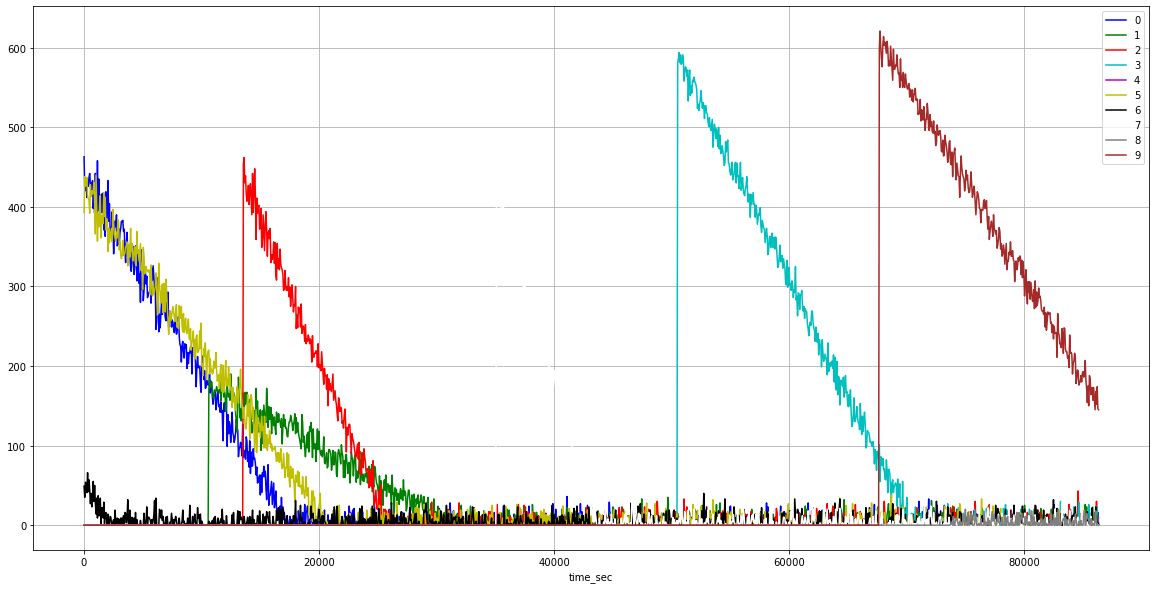

In [120]:


# plt.scatter(df['time2'], df['value'], s=0.1)


ax = df_sim_result.plot(kind='line', color='b', x='time_sec', y='0', label="0", figsize=(20, 10));
clrs = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'gray', 'brown']

for i in range(1,10,1):
    df_sim_result.plot(kind='line', color=clrs[i], x='time_sec', y=str(i), label=str(i), ax=ax);
plt.grid()

In [3]:
class Arm:
    
    def __init__(self, time_start, time_finish, noise_width):
        self.time_start = time_start # время начала симуляции
        self.time_finish = time_finish # время окончания симуляции
        
        self.noise_width = noise_width # величина стандартного отклонения шума
        self.fun = self._get_fun() # сгенерировать функцию изменения вероятности
    
    def _get_fun(self):
        # подготовить закон изменения вероятности для руки
        return Probability_fun(self.time_start, self.time_finish)
    
    def get_probability(self, t):
        # рассчитать вероятность для момента времени t
        value = self.fun.get_value(t)
        if value > 0:
            noise = np.random.normal(0, self.noise_width) # шум
            result = value + noise
            if result < 0:
                return 0
            else:
                return result
        else:
            return 0

start_dt = datetime.datetime.now()
finish_dt = start_dt + datetime.timedelta(days=1)
arm = Arm(time_start=start_dt,
          time_finish=finish_dt,
          noise_width=0.1)

arm.get_probability(40)

0

In [4]:
d = []
for t in tqdm(range(int((finish_dt-start_dt).total_seconds()))):
    d.append({"time": t, "value": arm.get_probability(t)})

df = pd.DataFrame(d)
df['time2'] = df['time'].apply(lambda x: start_dt + datetime.timedelta(seconds=x))

  0%|          | 0/86400 [00:00<?, ?it/s]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86400 entries, 0 to 86399
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    86400 non-null  int64         
 1   value   86400 non-null  float64       
 2   time2   86400 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.0 MB


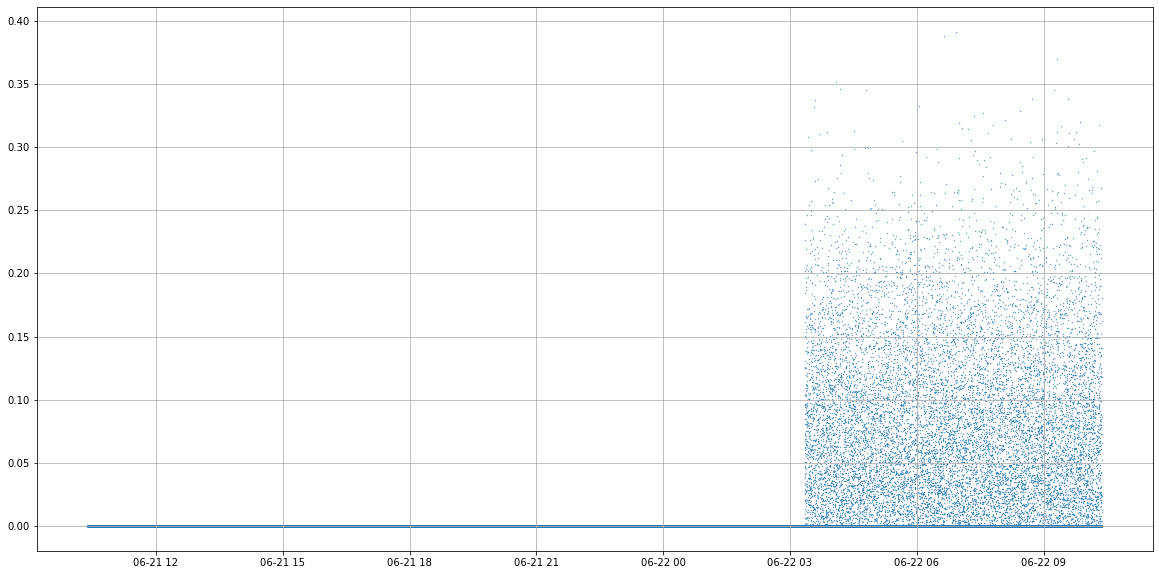

In [6]:
plt.figure(figsize=(20, 10))

plt.scatter(df['time2'], df['value'], s=0.1)
plt.grid()

In [2]:
class Probability_fun:
    
    def __init__(self, time_start, time_finish):
        self.time_sim_start = time_start
        self.time_sim_finish = time_finish
        self.time_gen_start = self.time_sim_start - (self.time_sim_finish - self.time_sim_start)*0.1
        # посчитаем диапазон генерации функций (- 10% от разницы к старту)  
        self._generate_coef() # сгенерировать коэффициенты функции
        
    def _generate_coef(self):
        # генерируем коэффициенты
        self.tilt_shift = np.random.rand() * 0.0005 # коэффициент угла наклона
        self.ampl_shift = (np.random.rand() - 0.3)*10 # коэффициент добавочной высоты
        self.time_shift = ((self.time_sim_finish - self.time_gen_start) * np.random.rand()).total_seconds() 
        # коэффициент временного сдвига (измеряется в секундах)
    
    def get_value(self, time):
        # генерируем значение функции
        value = -(time - self.time_shift)*self.tilt_shift
        if value > 1:
            return 0
        
#         if value < 0:
        value = value + self.ampl_shift
        
        if value < 0:
            return 0.01
        else:
            return value